In [1]:
import math

from portfolio import Portfolio
from backtest import Backtest
from strategies import *
from config import *
from utils import plot_distribution, PolygonAPI
from data_processing import *

In [2]:
# get SPY data
spy_df = get_spy_data(start_date, end_date)
print("Number of days to backtest: ", len(spy_df))
spy_df.head(5)

Number of days to backtest:  496


,Date,Open,High,Low,Close,Adj Close,Volume
5408,2022-07-01,376.559998,381.700012,373.799988,381.239990,369.939941,74839700
5409,2022-07-05,375.880005,381.980011,372.899994,381.959991,370.638580,81438000
5410,2022-07-06,382.109985,385.869995,379.600006,383.250000,371.890381,70426200
5411,2022-07-07,385.119995,389.829987,383.269989,388.989990,377.460205,64525900
5412,2022-07-08,387.269989,390.640015,385.660004,388.670013,377.149750,72397800


In [3]:
# instantiation
my_portfolio = Portfolio(initial_portfolio_nominal_value, portolio_weights_config, collateral_ratio)
my_strategy = ZeroCostCollar0DTE(my_portfolio, 'SPY', spy_df)
env = Backtest(my_portfolio, spy_df, PolygonAPI(api_key='MPkBRXXyfleZXSJQp8_bOsKuqo2Wi_Gk'))

# If price data is not available on Polygon.io, the BS model will be used to calculate price, which will print relevant info
if strategy_selected == 1:
    env.get_option_price('SPY', bs_config, zero_cost_search_config, open_price_config)
    my_strategy.find_zero_cost_collar(env)
elif strategy_selected == 2:
    my_strategy.select_options(env.main_df, strike_selection_config)
    env.get_option_price('SPY', bs_config)
else:
    raise ValueError("Check config, strategy does not exist. ")

env.update_option_price_at_expiration()
my_strategy.update_collar_pnl(env.main_df)

Fetching option prices using multithreading: 100%|██████████| 14002/14002 [02:42<00:00, 85.95it/s] 



Used BS model on the following days and options:
2022-07-07 for K=379 call 
2022-07-07 for K=380 call 
2022-07-07 for K=381 call 
2022-07-07 for K=383 call 
2022-07-07 for K=384 call 
2022-07-07 for K=389 call 
2022-07-07 for K=387 call 
2022-07-07 for K=390 call 
2022-07-07 for K=382 call 
2022-07-07 for K=385 call 
2022-07-07 for K=386 call 
2022-07-07 for K=386 put 
2022-07-07 for K=380 put 
2022-07-07 for K=379 put 
2022-07-07 for K=384 put 
2022-07-07 for K=385 put 
2022-07-07 for K=383 put 
2022-07-07 for K=388 put 
2022-07-07 for K=390 put 
2022-07-07 for K=387 put 
2022-07-07 for K=381 put 
2022-07-07 for K=382 put 
2022-07-07 for K=389 put 
2022-07-07 for K=388 call 
2022-07-12 for K=377 call 
2022-07-12 for K=378 call 
2022-07-12 for K=381 call 
2022-07-12 for K=380 call 
2022-07-12 for K=382 call 
2022-07-12 for K=379 call 
2022-07-12 for K=385 call 
2022-07-12 for K=387 call 
2022-07-12 for K=381 put 
2022-07-12 for K=389 call 
2022-07-12 for K=380 put 
2022-07-12 for K=37

In [4]:
# Buy and hold SPY at market open on Day 1
first_date = env.main_df['Date'].values[0]
first_price = env.main_df['Open'].values[0]

target_spy_exposure = my_portfolio.initial_portfolio_nominal_value * my_portfolio.target_portfolio_weights['equity']
n_spy_to_buy = math.floor(target_spy_exposure / first_price)
my_strategy.execute_buy_and_hold_underlying('equity', first_date, first_price, n_spy_to_buy)

print('Portfolio position:', my_portfolio.positions)
print('Cash after buying SPY:', my_portfolio.cash)
print('Transaction history')
my_portfolio.print_transaction_history()

Portfolio position: {'equity': {'SPY': 2124}}
Cash after buying SPY: 200186.56
Transaction history
2022-07-01: ['bought 2124 SPY at 376.56 on 2022-07-01.']


In [5]:
# Run the zero-cost collar strategy every day in spy_df
# If an error occurs during env.run() due to insufficient cash, the following charts can still be generated.
env.run(my_strategy)


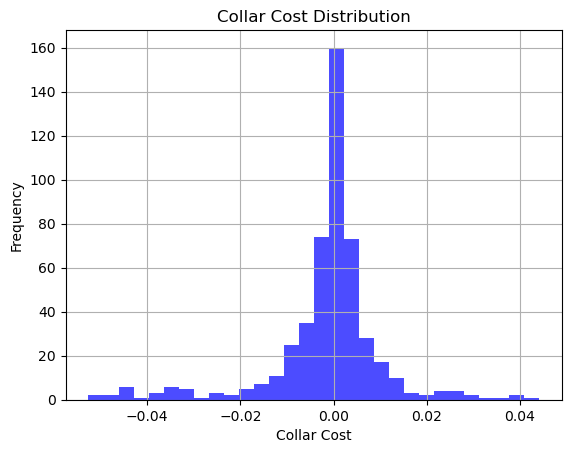

In [6]:
# Plot the distribution of collar strategy cost. Negative cost means the call premium is larger than put premium (i.e. receiving a credit to open)
plot_distribution(env.main_df['collar_cost'], x_label='Collar Cost', title='Collar Cost Distribution')

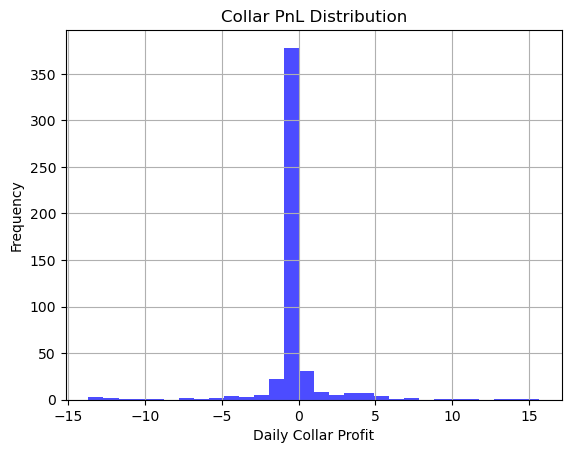

In [7]:
# Plot the distribution collar strategy PnL
plot_distribution(env.main_df['collar_pnl'], x_label='Daily Collar Profit', title='Collar PnL Distribution')

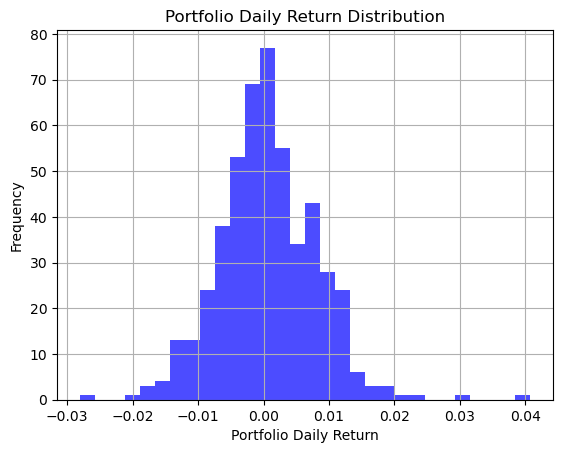

In [8]:
port_return = my_portfolio.calc_port_daily_return()
plot_distribution(port_return, x_label='Portfolio Daily Return', title='Portfolio Daily Return Distribution')

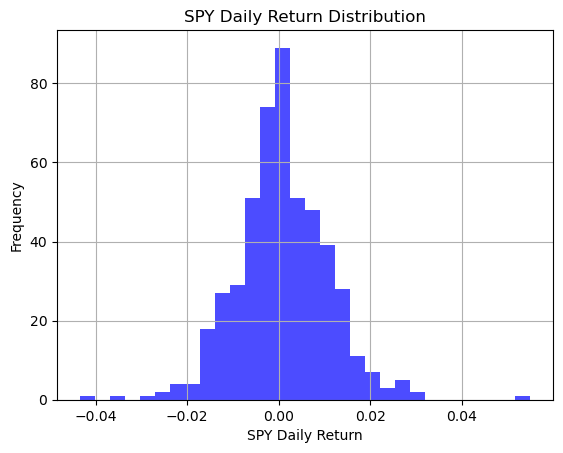

In [9]:
spy_return = env.calc_benchmark_return()
plot_distribution(spy_return, x_label='SPY Daily Return', title='SPY Daily Return Distribution')

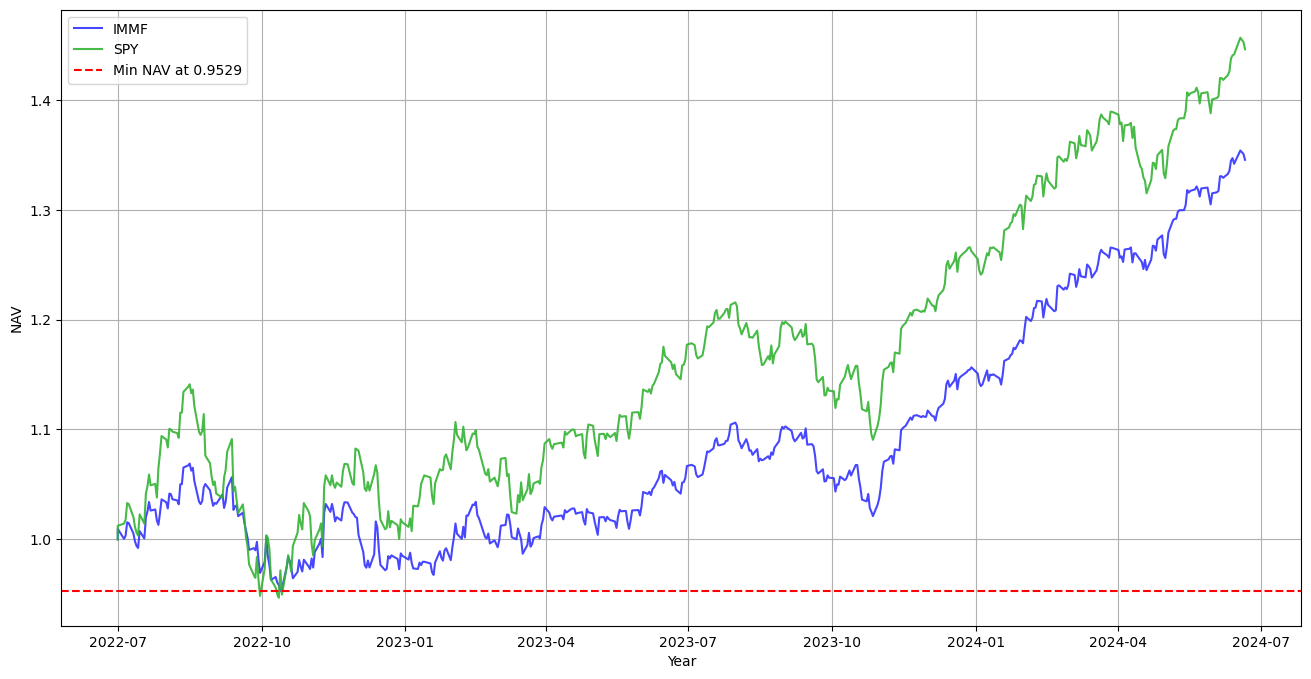

In [10]:
env.plot_nav_vs_spy()

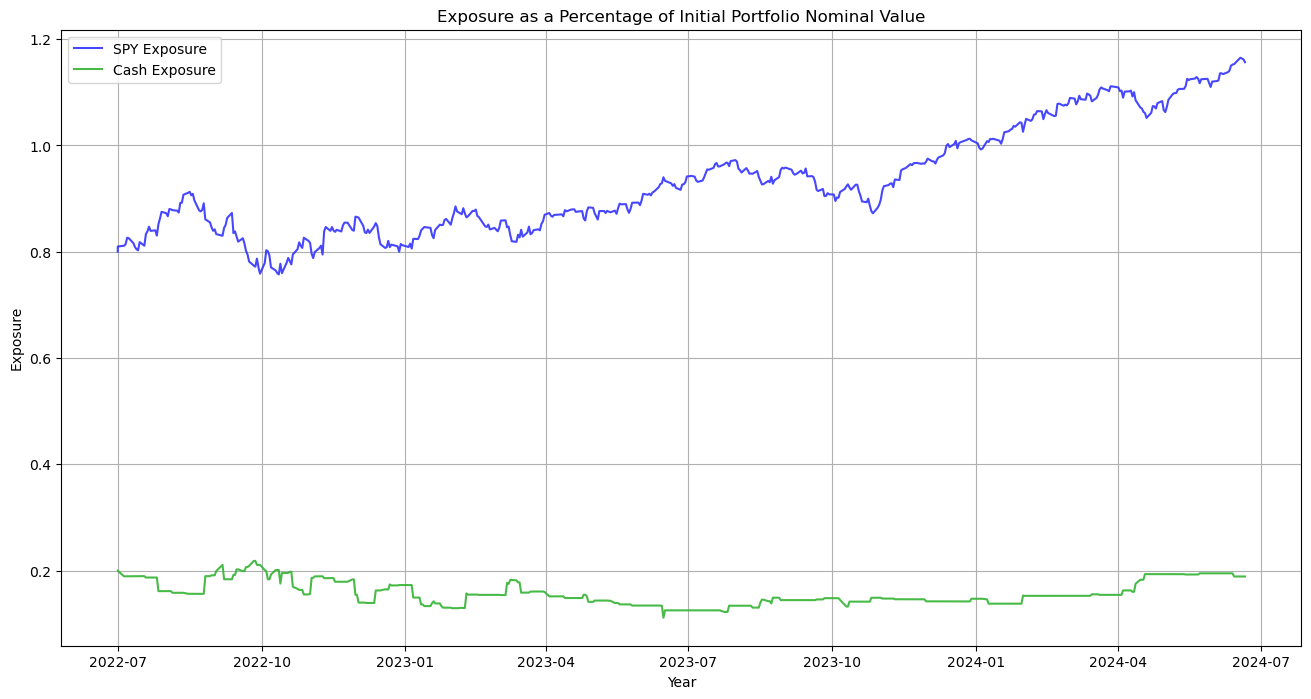

In [11]:
env.plot_exposure()

In [12]:
# Optional commands which could be useful for further review and analysis.

# Save the backtest main dataframe to the data folder
# env.save_main_df_to_csv()

# Save transaction history to the data folder
# my_portfolio.save_transaction_history_to_csv()

# Print all transaction history in the backtest
# my_portfolio.print_transaction_history()

# Print portfolio attributes
# print(my_portfolio.positions, my_portfolio.cash, my_portfolio.margin)
